This notebook is dedicated to exploring ways to tackle the problem of class imbalance in classificaion problems.

#### Problem
Class imbalance is the product of skewness in distribution towards some particular class(-es):
    
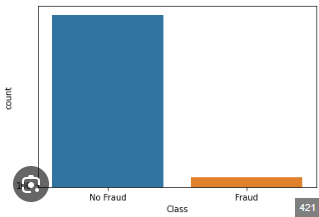

Imbalance can lead to model's underperformance in zero-shot problems, as it will always be more biased towards the prevailing class. Prominent examples of class imbalance problems:
* Medical research (there are always less positive cases than negative ones)
* Default detection (in banking default on credit is quite a rare occurence, hence it's difficult to make the model assess risks adequately)

#### Ways to tackle the problem
* **data** manipulations
* **loss functions'** manipulations
* **models'** manipulations
* using specialized **tools** like [imbalanced-learn](https://imbalanced-learn.org/stable/index.html) on top of scikit-learn

#### Data manipulations

Data manipulations entail upsampling/downsampling of data in a way that allows our distribution to stay balanced. Techniques that are commonly used:
* upsampling
    * bootstrapping
    * SMOTE
    * ADASYN
* downsampling
    * at random
    * NearMiss
    * Tomek Links
    * Cluster-Centroid Undersampling
    * Edited Nearest Neighbors
    * Condensed Nearest Neighbors
* augmentations

#### Upsampling

**Bootstrapping**

Bootstrapping is a method of uniformly sampling subsamples from the distribution with replacement (items are "put back" after having been sampled). Of course this method is quite versatile and open to any weighting/conditional sampling and other advanced usecases

**SMOTE**

SMOTE algorithm can be intuitively described as follows:
* Sample a random point (vector $r_0$) from the minority class;
* Find $k$ (a hyperparameter) nearest neighbors closest to it;
* Then we can choose $m$ random points on the linear plane between $k$ points and the original randomly selected point. For that matter we can get the vector's equation: $r(t)=r_0+t\times V, t\in[0, 1]$, where $V=r_k-r_0$ - a directional vector;
* Repeat until a certain upsampling threshold of $\% P=[100,\infty]$ of the the minority sample is met

**ADASYN**
* Consider we have $x$ as majority set of features and $y$ as a minority;
* For each minority point we find $k$ closest neighbors and calculate the ratio of nieghbors in the majority class amongst all neighbors $K$. That would be minority point's weight $w_i=\frac{\# Y_{y\in K}}{\# K}$;
* For each point that has a $w_i>0$ we calculate same linear planes that we then populate for as long as their own $w_i$ is equal to $0$

#### Downsampling

**At random**
Just like in bootsrapping we could randomly exclude subsets of the major class until we reach some balance in distribution amongst classes

**NearMiss**
* Until some "balance" threshold is reached:
    * for each point of the majority class get $k$ nearest neighbours from the minority class
    * now we can remove points from the majority class in two ways:
        * remove those that have the smallest average distance amongst $k$ neighbors
        * or remove those that have smallest average distance amongst $k$ **furthest** neighbors

**Tomek links**
* practically same idea as NearMiss. Until some "balance" is reached:
    * for each majority instance we calculate $k=1$ nearest neighbours from the minority class;
    * remove a majority point that has the lowest distance;

**Cluster-Centroid Undersampling**

The idea of this algorithm is creating clusters inside the majority set. With each cluster we get its centroid, which we'll keep and get rid of the rest. We then cluster our data until a number of centroids satisfy some "balance" amongst original classes

**Edited Nearest Neighbors**

For each majority point we calculate k nearest neighbors. We then get rid of those that have any or a big fraction of minority samples amongst their neighbors

**Condensed Nearest Neighbours**

Same as the previous method, but $k=1$. This method is very susceptible to noise, so it must be used in a group of other resampling methods

All of the above methods are available inside the [imbalanced learn](https://imbalanced-learn.org/stable/auto_examples/under-sampling/plot_comparison_under_sampling.html#sphx-glr-auto-examples-under-sampling-plot-comparison-under-sampling-py)

#### Augmentations

We generate synthetic data in order to balance out the distribution. A common practice is to use augmentations in images. A very popular API for that matter is called [Albumentations](https://albumentations.ai/)

#### Loss functions' manipulations

This approach is **better** than everything discussed before. We can always modify our objective function in order to penalize predicitons for majority classes. In this notebook, however, we'll only focus on distribution-based losses:
* weighted BCE/CE
* Focal loss

Commonly extended loss functions are used in segmentation problems due to the complexity of the data. Here's a good diagram that pretty much summarizes them:

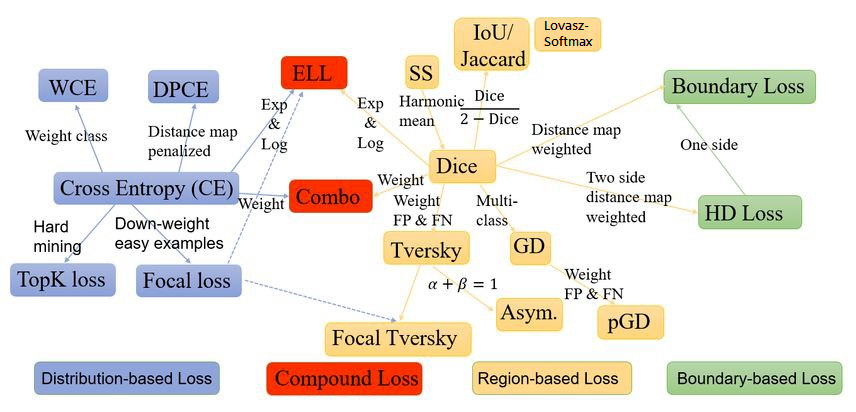

**Weighted BCE (BCEwithLogitLoss)**

Firstly, we should highlight the fact that BCE can be in fact used for "multi-label" $[1]$ classification, but not "multi-class" $[2]$.

$[1]$ means that we have $N$ classes, each having a sigmoid function put on top of it, which answers a "yes"/"no" question for each label. It does not specifically understand the task of identifying a single correct label across all labels, hence it is called a "multi-label" and not a "mulit-class" problem. $[2]$ searches across all classes and is specifically designed for searching for the best class across all other classes.

In binary classification, where class imbalance usually plays a key role in zero-shot problems, the loss can be weighted out via the $p_c$ paramter available in `BCEwithLogitLoss()` as a `pos_weight` argument of a broadcastable shape $C\times1$ (where $C$ is the number of classes) in pytorch that also expects logits as inputs. As stated in the [docs](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html), $p_c>1$ increases recall, while $p_c<1$ increases precision:
$$
l_{n, c}=-w_{n, c}\left[p_c y_{n, c} \cdot \log \sigma\left(x_{n, c}\right)+\left(1-y_{n, c}\right) \cdot \log \left(1-\sigma\left(x_{n, c}\right)\right)\right]
$$

**Focal loss**

Focal loss (https://arxiv.org/pdf/1708.02002) can be used as another extension of the BCE:
$$
FL(p_c)=\alpha_c(1-p_c)^\gamma log(p_c)
$$
Here, apart from assigning hard-coded weights, we also penalize the model for estimating low probabilties for the positive class, that is usually have a pretty low presence in the distribution:

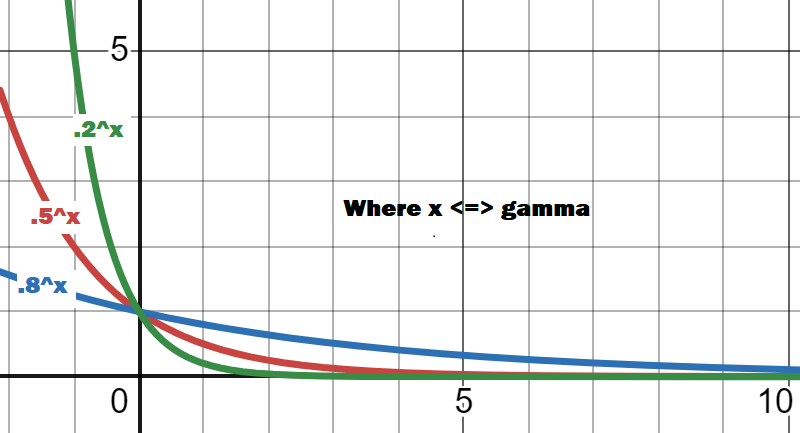



#### models' manipulations

Just like in loss functions, we're able to add penalizations to models via regularizations. Almost all binary classification models allow weighted regularizations, e.g.:

* Weighted SVM, that adds missclassification penalties of significance $C^+$ for the positive class and $C^-$ for another one:
    $$
    SVM_{weighted} \left\{\begin{array}{c}
    \min _{w, \xi \geq 0} \frac{\|w\|^2}{2}+C^{+} \sum_{i: y_i=0} \xi_i+C^{-} \sum_{i: y_i=1} \xi_i \\
    \text { s.t } \\
    y_i\left(w x_i+b\right) \geq 1-\xi_i \forall i
    \end{array}\right.
    $$
* [J regularization](https://arxiv.org/pdf/1910.09783) [segmentation]


#### Metrics for classification on imbalanced datasets

* [Matthews correlation coefficient](https://www.researchgate.net/publication/351896197_The_Matthews_Correlation_Coefficient_MCC_is_More_Informative_Than_Cohen's_Kappa_and_Brier_Score_in_Binary_Classification_Assessment) [binary]
* AUPRC (AU Precision-Recall curve) (just like in ROC-AUC, the best value is $1$ (with ever-increasing recall precision stays the same)). It's also interchargeably used with AP (average precision formula), as could be seen here: https://sanchom.wordpress.com/tag/average-precision/
* weighted F1 ($\frac{2TP}{2TP+FP+FN}$), that takes into consideration number of occurencies of a certain class in the dataset
* Jaccard index: $\frac{TP}{TP+FP+FN}$, that takes inspiration from measuring quality of segmentation models and, unlike the F1-score, is more sensitive to single instances of bad classification